In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import logging
import math

import faiss
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
import tqdm

from ann_solo import reader, spectral_library
from ann_solo.config import config
from ann_solo.spectrum import process_spectrum, spectrum_to_vector

In [3]:
tqdm.tqdm = tqdm.tqdm_notebook

# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # single-column figure

In [4]:
config_filename = '../../bin/ann-solo/iprg2012.ini'
splib_filename = '../../data/interim/iprg2012/human_yeast_targetdecoy.splib'
mgf_filename = '../../data/external/iprg2012/iPRG2012.mgf'
mztab_filename = '../../data/processed/iprg2012/brute_force/bf_oms_shifted.mztab'

In [5]:
config.parse(f'--config {config_filename} --no_gpu '
             f'{splib_filename} {mgf_filename} dummy.mztab')

In [6]:
ssms = reader.read_mztab_ssms(mztab_filename)

In [7]:
ssms['mass_diff_Da'] = (ssms['exp_mass_to_charge'] -
                        ssms['calc_mass_to_charge']).abs() * ssms['charge']
ssms['mass_diff_ppm'] = ((ssms['exp_mass_to_charge'] -
                          ssms['calc_mass_to_charge']).abs()
                         / ssms['calc_mass_to_charge'] * 10**6)
ssms_open = ssms[ssms[f'mass_diff_{config.precursor_tolerance_mode}'] >
                 config.precursor_tolerance_mass]
ssms_open = ssms_open[ssms_open['charge'].isin((2, 3))]
ssms_open = ssms_open.sort_values('charge')

In [8]:
query_spectra = {}
for spectrum in reader.read_mgf(mgf_filename):
    spectrum_id = int(spectrum.identifier)
    if spectrum_id in ssms_open.index:
        spectrum.precursor_charge = ssms_open.loc[spectrum_id]['charge']
        query_spectra[spectrum_id] = process_spectrum(spectrum, False)

In [9]:
lib_reader = reader.SpectralLibraryReader(splib_filename)
lib_reader.open()

In [10]:
charge_vectors = {
    charge: np.zeros((len(lib_reader.spec_info['charge'][charge]['id']),
                      config.hash_len), np.float32)
    for charge in (2, 3)}
i = {charge: 0 for charge in charge_vectors.keys()}
for lib_spectrum, _ in tqdm.tqdm(
        lib_reader.get_all_spectra(), desc='Library spectra added',
        leave=False, unit='spectra', smoothing=0.1):
    charge = lib_spectrum.precursor_charge
    if charge in charge_vectors.keys():
        spectrum_to_vector(process_spectrum(lib_spectrum, True),
                           config.min_mz, config.max_mz,
                           config.bin_size, config.hash_len, True,
                           charge_vectors[charge][i[charge]])
        i[charge] += 1
# Build an individual FAISS index per charge.
logging.info('Build the spectral library ANN indexes')
ann_indexes = {}
for charge, vectors in charge_vectors.items():
    logging.debug('Create a new ANN index for charge %d', charge)
    ann_index = faiss.IndexFlatIP(config.hash_len)
    ann_index.train(vectors)
    ann_index.add(vectors)
    ann_indexes[charge] = ann_index

In [11]:
nn_idx = []
num_neighbors = 1000000    # Retrieve all neighbors.
for query_id, ssm in tqdm.tqdm(ssms_open.iterrows(),
                               total=len(ssms_open), unit='SSMs'):
    query_spectrum = query_spectra[query_id]
    query_vector = spectrum_to_vector(query_spectrum, config.min_mz,
                                      config.max_mz, config.bin_size,
                                      config.hash_len, True)
    ann_index = ann_indexes[ssm['charge']]
    dist, neighbors = ann_index.search(query_vector.reshape(1, -1),
                                       num_neighbors)
    lib_neighbors = (lib_reader.spec_info['charge'][ssm['charge']]['id']
                     [neighbors])
    match_idx = np.where(lib_neighbors == ssm['accession'])[1]
    nn_idx.append((match_idx[0], ssm['search_engine_score[1]'],
                   dist[0][match_idx][0]))

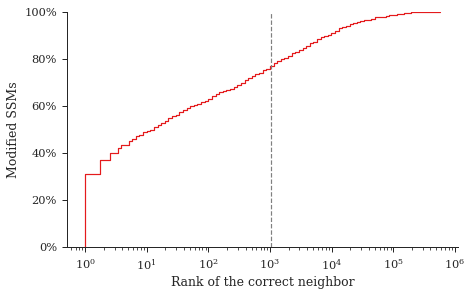

In [12]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

idx = np.asarray([idx for idx, _, _ in nn_idx]) + 1
hist, bins = np.histogram(idx,
                          bins=np.logspace(np.log10(idx.min()),
                                           np.log10(idx.max()), 100))
ax.step(np.insert(bins[:-1], 0, 1),
        np.insert(np.cumsum(hist) / len(idx), 0, 0))

ax.axvline(1024, ls='--', c='gray')

ax.set_ylim(0, 1)

ax.set_xscale('log')

ax.set_xlabel('Rank of the correct neighbor')
ax.set_ylabel('Modified SSMs')

ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

sns.despine()

plt.savefig('num_neighbors_cum.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [13]:
for nn in [1, 10, 1024, 5000]:
    print(f'Percentage of SSMs correctly identified using {nn:4d} neighbors:'
          f' {len(np.where(idx <= nn)[0]) / len(idx):.1%}')
for perc in [0.9, 0.95, 0.99]:
    print(f'Number of neighbors needed to identified {perc:.0%} of SSMs: '
          f'{math.ceil(bins[np.argmax(np.cumsum(hist) / len(idx) >= perc)]):7,}')

Percentage of SSMs correctly identified using    1 neighbors: 30.9%
Percentage of SSMs correctly identified using   10 neighbors: 48.1%
Percentage of SSMs correctly identified using 1024 neighbors: 75.1%
Percentage of SSMs correctly identified using 5000 neighbors: 85.4%
Number of neighbors needed to identified 90% of SSMs:   9,916
Number of neighbors needed to identified 95% of SSMs:  25,569
Number of neighbors needed to identified 99% of SSMs: 148,492


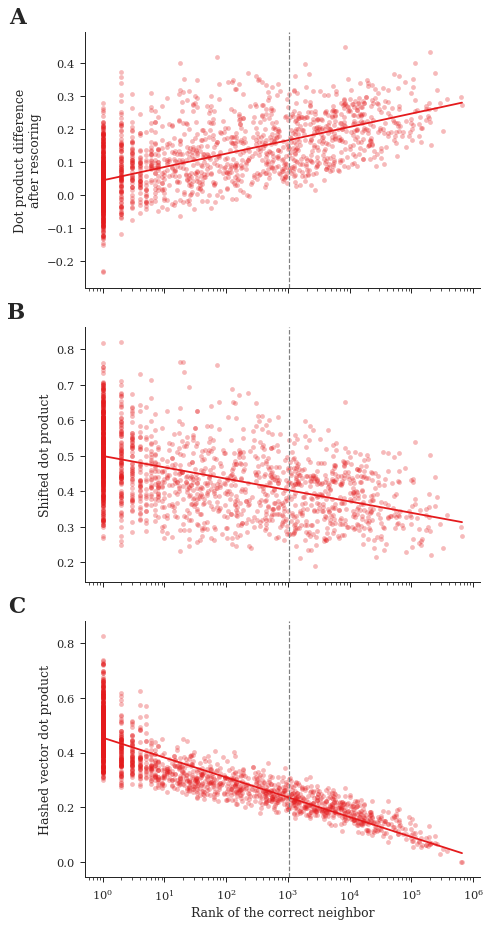

In [14]:
width = 7
height = width / 1.618    # golden ratio
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(width, height * 3))

idx = np.asarray([idx for idx, _, _ in nn_idx]) + 1
score_diff = [score_spec - score_vec for _, score_spec, score_vec in nn_idx]
sns.regplot(idx, score_diff, ci=None, logx=True, truncate=True,
            color='C0', scatter_kws={'alpha': 0.3}, ax=axes[0])
score_spec = [score_spec for _, score_spec, _ in nn_idx]
sns.regplot(idx, score_spec, ci=None, logx=True, truncate=True,
            color='C0', scatter_kws={'alpha': 0.3}, ax=axes[1])
score_vec = [score_vec for _, _, score_vec in nn_idx]
sns.regplot(idx, score_vec, ci=None, logx=True, truncate=True,
            color='C0', scatter_kws={'alpha': 0.3}, ax=axes[2])

for ax in axes:
    ax.axvline(1024, ls='--', c='gray')
    ax.set_xscale('log')
    
for i, (ax, c) in enumerate(zip(axes, 'ABC')):
    ax.text(-0.15, 1.1, c, transform=ax.transAxes, fontsize='xx-large',
            weight='bold', va='top', ha='right')
    
axes[2].set_xlabel('Rank of the correct neighbor')
axes[0].set_ylabel('Dot product difference\nafter rescoring')
axes[1].set_ylabel('Shifted dot product')
axes[2].set_ylabel('Hashed vector dot product')

sns.despine()

plt.tight_layout()

plt.savefig('num_neighbors_score.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [15]:
lib_reader.close()
for ann_index in ann_indexes.values():
    ann_index.reset()
logging.shutdown()